# Import

Import libraries and verify if GPU is found.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.applications.mobilenet import MobileNet
from keras.layers import Dense,Conv2D,MaxPooling2D,GlobalAveragePooling2D,Dropout,SeparableConv2D,BatchNormalization, Activation, Dense,Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import pickle 
from google.colab import drive
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

print("Tensorflow version %s" %tf.__version__)
print("Keras version %s" %keras.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


drive.mount('/content/drive')

Tensorflow version 2.4.0
Keras version 2.4.0
Found GPU at: /device:GPU:0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Pre-processing data

Load dataset from the drive.
Organizing and pre-processing the images of dataset.

In [ ]:
train_path = '/content/drive/MyDrive/HOMEWORK_2/dataset/train'
test_path = '/content/drive/MyDrive/HOMEWORK_2/dataset/test'

datadir = '/content/drive/MyDrive/HOMEWORK_2'
models_dir = datadir + '/models/'
results_dir = datadir + '/results/'


def savemodel(model,problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    model.save(filename)
    print("\nModel saved on file %s\n" %filename)

def savehistory(history,problem):
    filename = os.path.join(results_dir, '%s.hist' %problem)
    with open(filename, 'wb') as f:
        pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)
    print("\nHystory saved on file %s\n" %filename)

# data augmentation technique
train_datagen = ImageDataGenerator( rescale = 1. / 255, \
                                    zoom_range=0.1, \
                                    rotation_range=10, \
                                    width_shift_range=0.2, \
                                    height_shift_range=0.2, \
                                    horizontal_flip=True, \
                                    vertical_flip=False ) 
                              
test_datagen = ImageDataGenerator( rescale = 1. / 255) 

train_generator = train_datagen.flow_from_directory(
    directory=train_path, \
    target_size=(224, 224), \
    color_mode="rgb", \
    batch_size=64, \
    class_mode="categorical", \
    shuffle=True)

test_generator = test_datagen.flow_from_directory(
    directory=test_path, \
    target_size=(224, 224), \
    color_mode="rgb", \
    batch_size=64, \
    class_mode="categorical", \
    shuffle=False)

Found 6909 images belonging to 8 classes.
Found 2254 images belonging to 8 classes.


# MODEL B1

- Load MobileNet model (pre-trained on ImageNet). 
- Cut from MobileNet the last 2 convolutional layers.
- Addition of 5 Dense layers. The final one has the output equal to the number of classes that the model has to classify.

- Trainable layers: 5 final Dense layers + the last convolutional layer from MobileNet.
- Non-trainable layers: all the MobileNet layers (excpet the last two (which I removed) and the one I trained), plus the final dense layers

In [ ]:
# dataset has 8 classes
num_class = 8
input_shape  = train_generator.image_shape

# Base model with Fully connected Layers (I will cut them)
base_model = MobileNet(include_top=True, weights='imagenet', input_shape=(224,224,3))

name_output_base_model = "conv_pw_11_relu"
output_extractor = base_model.get_layer(name=name_output_base_model).output 

pooling = GlobalAveragePooling2D()(output_extractor)

# add 5 dense layers
dense1 = Dropout(0.4)(pooling)
dense1 = Dense(300,activation='relu', name="dense_11")(dense1) 

dense2 = Dropout(0.4)(dense1)
dense2 = Dense(128, activation='relu', name="dense_12")(dense2)

dense3 = Dropout(0.25)(dense2)
dense3 = Dense(64, activation='relu', name="dense_13")(dense3)

dense4 = Dropout(0.25)(dense2)
dense4 = Dense(64, activation='relu', name="dense_14")(dense4)

transfer_output = Dropout(0.25)(dense4)
transfer_output = Dense(units=8, activation='softmax', name="dense_15")(transfer_output)

transfer_model = Model(inputs=base_model.input, outputs=transfer_output)

trainable_layers = ["conv_dw_11","conv_dw_11_bn", "conv_pw_11","conv_pw_11_bn","dense_11", "dense_12", "dense_13", "dense_14", "dense_15"]

# set the feture extractor layers as non-trainable
for idx,layer in enumerate(transfer_model.layers):
  if layer.name in trainable_layers:
    layer.trainable = True
  else:
    layer.trainable = False

transfer_model.summary()

print("n° of layers of MobileNet: %d" %len(base_model.layers))
print("n° of layers of my transfer model: %d" %len(transfer_model.layers))



17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
______________________________________________________________

Set the learning rate and the decay rate.
Compile the model with Adam optimizer and categorical crossentropy loss function. 


In [ ]:
epochs = 40
learning_rate = 0.0004
decay_rate = learning_rate / epochs
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, decay=decay_rate)
transfer_model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

# Train MODEL B1

In [ ]:
steps_per_epoc = train_generator.n//train_generator.batch_size 
validation_step = test_generator.n//test_generator.batch_size+1 
transfer_history = transfer_model.fit(x = train_generator,
                   steps_per_epoch = steps_per_epoc,
                   validation_data = test_generator, 
                   validation_steps = validation_step,
                   epochs = 30)

#Save trained model and hystory
problemname = 'MobileNet-trasferlearning-b'
savemodel(transfer_model,problemname)
savehistory(transfer_history,problemname)

Epoch 1/30
107/107 [==============================] - 29s 256ms/step - loss: 2.1449 - accuracy: 0.1604 - val_loss: 1.7854 - val_accuracy: 0.3319
Epoch 2/30
107/107 [==============================] - 26s 240ms/step - loss: 1.6664 - accuracy: 0.3441 - val_loss: 1.8142 - val_accuracy: 0.3185
Epoch 3/30
107/107 [==============================] - 26s 238ms/step - loss: 1.2214 - accuracy: 0.5358 - val_loss: 1.1903 - val_accuracy: 0.5630
Epoch 4/30
107/107 [==============================] - 25s 237ms/step - loss: 1.0313 - accuracy: 0.6397 - val_loss: 0.7951 - val_accuracy: 0.7329
Epoch 5/30
107/107 [==============================] - 25s 236ms/step - loss: 0.8742 - accuracy: 0.7091 - val_loss: 0.6587 - val_accuracy: 0.7897
Epoch 6/30
107/107 [==============================] - 26s 243ms/step - loss: 0.7476 - accuracy: 0.7618 - val_loss: 0.5733 - val_accuracy: 0.8163
Epoch 7/30
107/107 [==============================] - 25s 238ms/step - loss: 0.6490 - accuracy: 0.7889 - val_loss: 0.5685 - val_ac

Plot the confusion matrix.

Confusion matrix, without normalization
[[231   6  18  11  12   1  18   7]
 [  4 288   8   5   4   5  29   7]
 [  5   3 277   5   3   3   3   1]
 [  0   3   1 187   3   0   3   3]
 [  8   0   2   5 265   0  19   1]
 [  0   4   0   1   0 232   6   7]
 [  2   3   1   5   3   0 234   2]
 [  2   8   1   5   2  10  10 262]]


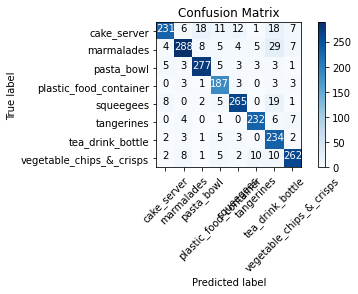

In [ ]:
predictions = transfer_model.predict(x=test_generator, steps=len(test_generator), verbose=0)

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cm = confusion_matrix(y_true=test_generator.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['cake_server', 'marmalades', 'pasta_bowl', 'plastic_food_container', 'squeegees', 'tangerines', 'tea_drink_bottle', 'vegetable_chips_&_crisps']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# Results of MODEL B1

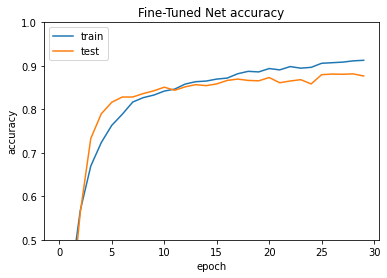

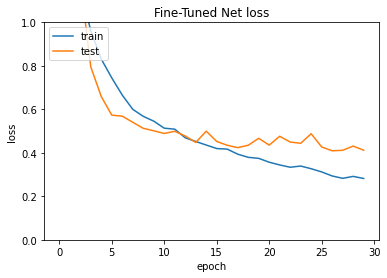

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history,name):

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(name + ' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.ylim(0.5,1.0)
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(name + ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim(0.0,1.0)
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

name="Fine-Tuned Net"
plot_history(transfer_history, name)

# MODEL B2 (fine-tuned model)

In [ ]:
# Base model without Fully connected Layers
model = MobileNet(include_top=True, weights='imagenet', input_shape=(224,224,3))

name_output_model = "conv_pw_9_relu"
output_extractor = model.get_layer(name=name_output_model).output 

# add first Convolutional Layer
conv_layer1 = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', name="conv_layer1")(output_extractor)
batch_n1=BatchNormalization()(conv_layer1)

# add second Convolutional Layer
conv_layer2 = Conv2D(filters=300, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', name="conv_layer2")(batch_n1)
# pooling
aver_pooling=GlobalAveragePooling2D()(conv_layer2)
# batch Normalization
batch_n2 = BatchNormalization()(aver_pooling)

flatten=Flatten()(batch_n2)

# add 5 final Dense layers 
dense1 = Dropout(0.4)(flatten)
dense1 = Dense(256,activation='relu', name="dense_11")(dense1) 

dense2 = Dropout(0.4)(dense1)
dense2 = Dense(128, activation='relu', name="dense_12")(dense2)

dense3 = Dropout(0.25)(dense2)
dense3 = Dense(64, activation='relu', name="dense_13")(dense3)

dense4 = Dropout(0.25)(dense2)
dense4 = Dense(64, activation='relu', name="dense_14")(dense4)

finetuned_output = Dropout(0.25)(dense4)
finetuned_output = Dense(units=8, activation='softmax', name="dense_16")(finetuned_output)

# instantiated our model
finetuned_model = Model(inputs=model.input, outputs=finetuned_output)

# set of trainable parameters
trainable_layers = ["conv_layer1","conv_layer2", "dense_11", "dense_12", "dense_13", "dense_14", "dense_15"]

for idx,layer in enumerate(model.layers):
  if layer.name in trainable_layers:
    layer.trainable = True
  else:
    layer.trainable = False


finetuned_model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
______________________________________________________________

Set the learning rate and the decay rate.
Compile the model with Adam optimizer and categorical crossentropy loss function. 


In [ ]:
epochs = 50
learning_rate = 0.0005
decay_rate = learning_rate / epochs
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, decay=decay_rate)
finetuned_model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

# Train MODEL B2

In [ ]:
steps_per_epoc = train_generator.n//train_generator.batch_size 
validation_step = test_generator.n//test_generator.batch_size+1 
finetuned_history = finetuned_model.fit(x = train_generator,
                   steps_per_epoch = steps_per_epoc,
                   validation_data = test_generator, 
                   validation_steps = validation_step,
                   epochs = 10)

#Save trained model and hystory
problemname = 'MobileNet-finetuned-b2'
savemodel(finetuned_model,problemname)
savehistory(finetuned_history,problemname)

Epoch 1/10
107/107 [==============================] - 510s 5s/step - loss: 0.4233 - accuracy: 0.8703 - val_loss: 0.7733 - val_accuracy: 0.8146
Epoch 2/10
107/107 [==============================] - 509s 5s/step - loss: 0.4039 - accuracy: 0.8740 - val_loss: 0.8124 - val_accuracy: 0.7768
Epoch 3/10
107/107 [==============================] - 509s 5s/step - loss: 0.3827 - accuracy: 0.8801 - val_loss: 0.5399 - val_accuracy: 0.8492
Epoch 4/10
107/107 [==============================] - 509s 5s/step - loss: 0.3839 - accuracy: 0.8815 - val_loss: 0.7060 - val_accuracy: 0.8150
Epoch 5/10
107/107 [==============================] - 509s 5s/step - loss: 0.3684 - accuracy: 0.8837 - val_loss: 0.7732 - val_accuracy: 0.8057
Epoch 6/10
107/107 [==============================] - 508s 5s/step - loss: 0.3584 - accuracy: 0.8909 - val_loss: 0.6976 - val_accuracy: 0.8110
Epoch 7/10
107/107 [==============================] - 508s 5s/step - loss: 0.3529 - accuracy: 0.8869 - val_loss: 0.9211 - val_accuracy: 0.7706

Plot the confusion matrix.

Confusion matrix, without normalization
[[231   2  37  11  14   0   8   1]
 [ 20 263  16   8   7  12  19   5]
 [ 11   1 281   4   2   0   1   0]
 [  1   0   3 186   3   0   4   3]
 [ 14   1   3   5 263   1  13   0]
 [  4   3   4   2   2 226   4   5]
 [ 10   5   9  13   7   0 204   2]
 [ 30   5  22   6   6  18   3 210]]


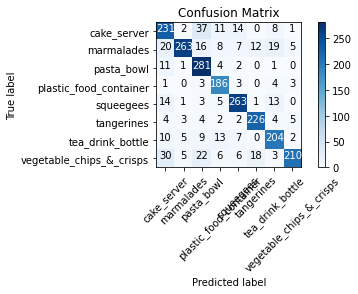

In [ ]:
predictions = finetuned_model.predict(x=test_generator, steps=len(test_generator), verbose=0)

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cm = confusion_matrix(y_true=test_generator.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['cake_server', 'marmalades', 'pasta_bowl', 'plastic_food_container', 'squeegees', 'tangerines', 'tea_drink_bottle', 'vegetable_chips_&_crisps']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# Results MODEL B2

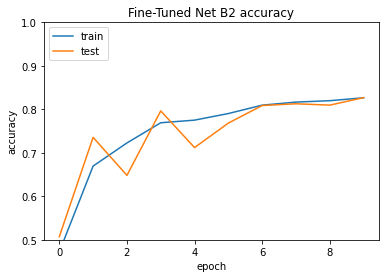

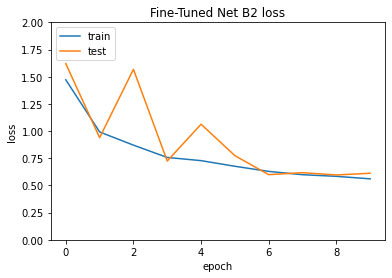

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history,name):

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(name + ' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.ylim(0.5,1.0)
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(name + ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim(0.0,2.0)
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

name="Fine-Tuned Net B2"
plot_history(finetuned_history, name)